In [2]:
import nltk
from nltk.corpus import twitter_samples, stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import re
import string
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random
from flask import Flask, request, jsonify

In [3]:
nltk.download('twitter_samples')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
nltk.download('twitter_samples') 

all_positive_tweets=twitter_samples.strings('positive_tweets.json') 
all_negative_tweets=twitter_samples.strings('negative_tweets.json') 
print('Number of positive tweets: ',len(all_positive_tweets)) 
print('Number of negative tweets: ',len(all_negative_tweets)) 

[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


Number of positive tweets:  5000
Number of negative tweets:  5000


In [5]:
def clean(tweet):

    tweet = tweet.translate(str.maketrans('','',string.punctuation))

    fjalet = word_tokenize(tweet)
    stop_words = set(stopwords.words('english'))
    stemmer = PorterStemmer()

    fjalet_e_pastuara = []
    for fjale in fjalet:
        if(fjale.lower() not in stop_words):
            fjalet_e_pastuara.append(stemmer.stem(fjale.lower()))

    return ' '.join(fjalet_e_pastuara)

tweet_positive_cleaned = []
for tweet in all_positive_tweets:
    tweet_positive_cleaned.append(clean(tweet))

tweet_negative_cleaned = []
for tweet in all_negative_tweets:
    tweet_negative_cleaned.append(clean(tweet))


            

In [6]:
print("\nShembull i një tweet-i të pastruar:")
print(all_positive_tweets[0])
print(tweet_positive_cleaned[0])


Shembull i një tweet-i të pastruar:
#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)
followfriday franceint pkuchly57 milipolpari top engag member commun week


In [7]:
import pandas as pd

In [8]:
df_positive = pd.DataFrame({'Tweet': tweet_positive_cleaned})
df_negative = pd.DataFrame({'Tweet':tweet_negative_cleaned})

print("Positive Tweets: ")
print(df_positive.head())
print("\nNegative Tweets: ")
print(df_negative.head())

Positive Tweets: 
                                               Tweet
0  followfriday franceint pkuchly57 milipolpari t...
1  lamb2ja hey jame odd pleas call contact centr ...
2  despiteoffici listen last night bleed amaz tra...
3                                     97side congrat
4  yeaaaah yippppi accnt verifi rqst succeed got ...

Negative Tweets: 
                                               Tweet
0                                       hopeless tmr
1  everyth kid section ikea cute shame im nearli ...
2                   hegelbon heart slide wast basket
3               “ ketchburn hate japanes call bani ”
4                          dang start next week work


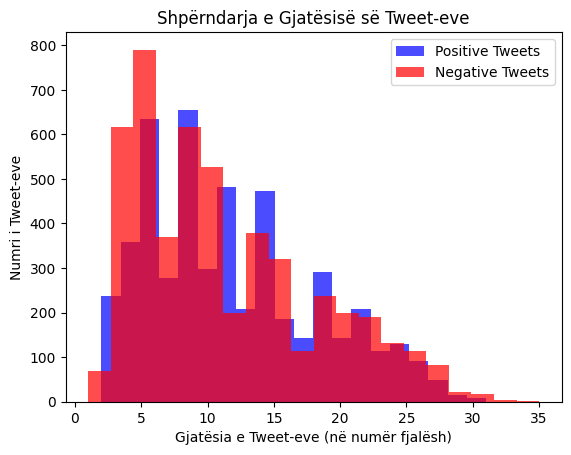

In [9]:
#Gjatesia e secilit Tweet ne numer fjalesh

lengths_positive = [len(tweet.split()) for tweet in all_positive_tweets]
lengths_negative = [len(tweet.split()) for tweet in all_negative_tweets]

plt.hist(lengths_positive, bins=20, alpha=0.7, label='Positive Tweets', color='blue')
plt.hist(lengths_negative, bins=20, alpha=0.7, label='Negative Tweets', color='red')

plt.title('Shpërndarja e Gjatësisë së Tweet-eve')
plt.xlabel('Gjatësia e Tweet-eve (në numër fjalësh)')
plt.ylabel('Numri i Tweet-eve')
plt.legend()
plt.show()

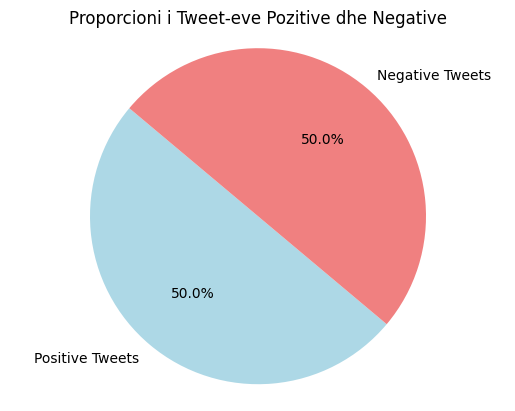

In [10]:
#Numri i Tweet-eve pozitive dhe negative
num_positive = len(all_positive_tweets)
num_negative = len(all_negative_tweets)

labels = ['Positive Tweets', 'Negative Tweets']
sizes = [num_positive, num_negative]
colors = ['lightblue', 'lightcoral']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Proporcioni i Tweet-eve Pozitive dhe Negative')
plt.axis('equal')  
plt.show()

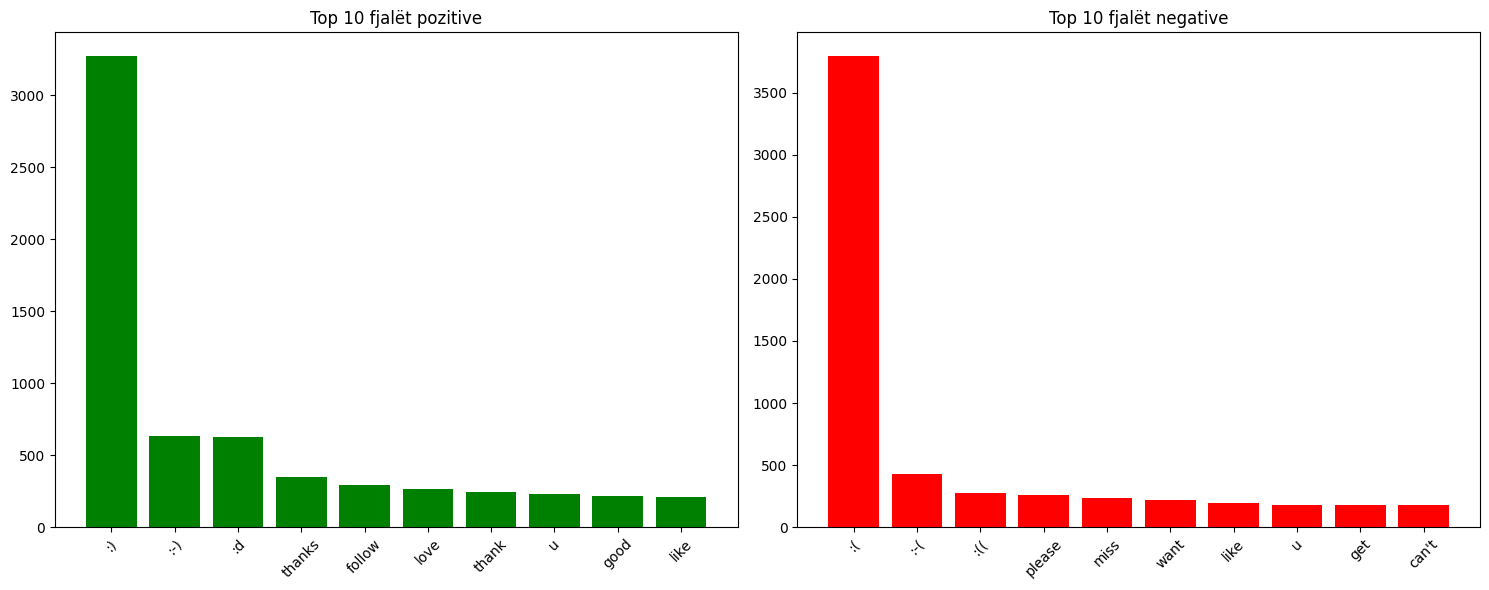

In [11]:
 #Top 10 fjalët (pa stopwords)
stop_words = set(stopwords.words('english'))
def get_top_words(tweets, n=10):
    words = [w.lower() for t in tweets for w in t.split() 
             if w.lower() not in stop_words]
    return Counter(words).most_common(n)

top_pos = get_top_words(all_positive_tweets)
top_neg = get_top_words(all_negative_tweets)

# Vizualizimi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

ax1.bar(*zip(*top_pos), color='g')
ax1.set_title('Top 10 fjalët pozitive')
ax1.tick_params(axis='x', rotation=45)

ax2.bar(*zip(*top_neg), color='r')
ax2.set_title('Top 10 fjalët negative')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

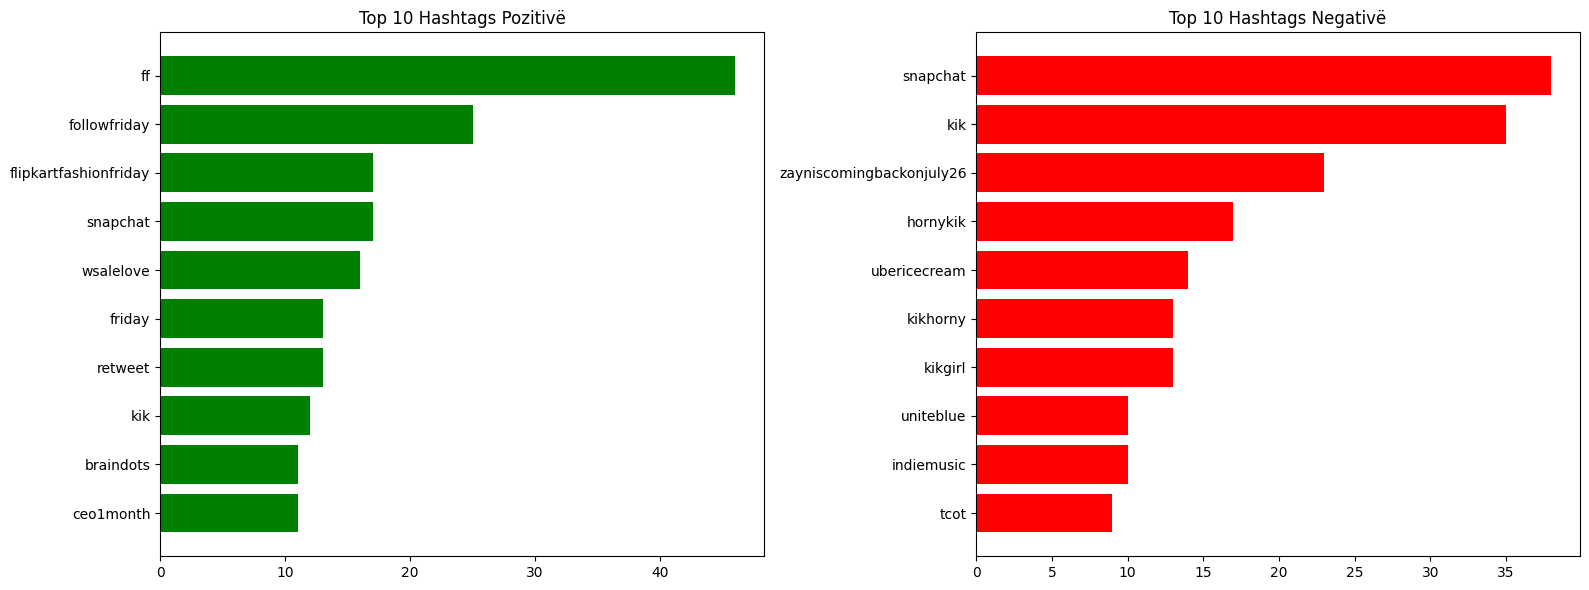

In [12]:
#most frequently used hashtags
import re
from collections import Counter
import matplotlib.pyplot as plt

def extract_top_hashtags(tweets, top_n=10):
    hashtags = []
    for tweet in tweets:
        found = re.findall(r'#(\w+)', tweet.lower())
        for hashtag in found:
            hashtags.append(hashtag)
    return Counter(hashtags).most_common(top_n)

all_tweets = all_positive_tweets + all_negative_tweets

top_hashtags = extract_top_hashtags(all_tweets)

top_pos_tags = extract_top_hashtags(all_positive_tweets)
top_neg_tags = extract_top_hashtags(all_negative_tweets)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

pos_tags_0 = []
for tag in top_pos_tags:
    pos_tags_0.append(tag[0])

pos_tags_1 = []
for tag in top_pos_tags:
    pos_tags_1.append(tag[1])

ax1.barh(pos_tags_0, pos_tags_1, color='green')
ax1.set_title('Top 10 Hashtags Pozitivë')
ax1.invert_yaxis()

neg_tags_0 = []
for tag in top_neg_tags:
    neg_tags_0.append(tag[0])

neg_tags_1 = []
for tag in top_neg_tags:
    neg_tags_1.append(tag[1])

ax2.barh(neg_tags_0, neg_tags_1, color='red')
ax2.set_title('Top 10 Hashtags Negativë')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

pos_tags = set()
for tag in top_pos_tags:
    pos_tags.add(tag[0])

neg_tags = set()
for tag in top_neg_tags:
    neg_tags.add(tag[0])


In [13]:
X = all_positive_tweets + all_negative_tweets
y = [1] * len(all_positive_tweets) + [0] * len(all_negative_tweets)  # 1=pozitiv, 0=negativ


combined = list(zip(X, y))
random.shuffle(combined)
X_shuffled, y_shuffled = zip(*combined)


split_idx = int(0.8 * len(X))
X_train, X_test = X_shuffled[:split_idx], X_shuffled[split_idx:]
y_train, y_test = y_shuffled[:split_idx], y_shuffled[split_idx:]

print(f"\nNumri i të dhënave trajnuese: {len(X_train)}")
print(f"Numri i të dhënave testuese: {len(X_test)}")


Numri i të dhënave trajnuese: 8000
Numri i të dhënave testuese: 2000


In [14]:
vectorizer = CountVectorizer()
X_train_vector = vectorizer.fit_transform(X_train)
X_test_vector = vectorizer.transform(X_test)

In [15]:
model = MultinomialNB()
model.fit(X_train_vector, y_train)

MultinomialNB()

In [16]:
y_pred = model.predict(X_test_vector)

In [17]:
accuracy = accuracy_score(y_test, y_pred)
print(f"\nSaktësia (Accuracy): {accuracy * 100:.2f}%")


Saktësia (Accuracy): 78.25%


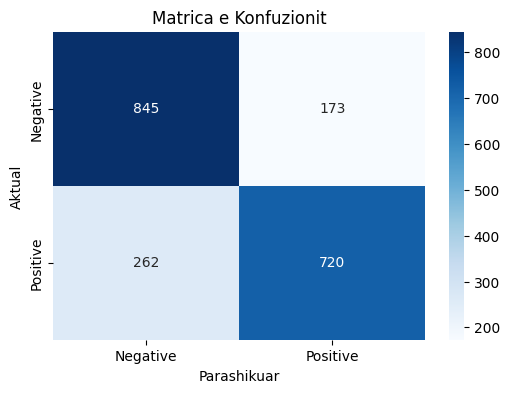

In [18]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Parashikuar')
plt.ylabel('Aktual')
plt.title('Matrica e Konfuzionit')
plt.show()

In [19]:
print("\nRaporti i Klasifikimit:")
print(classification_report(y_test, y_pred))


Raporti i Klasifikimit:
              precision    recall  f1-score   support

           0       0.76      0.83      0.80      1018
           1       0.81      0.73      0.77       982

    accuracy                           0.78      2000
   macro avg       0.78      0.78      0.78      2000
weighted avg       0.78      0.78      0.78      2000



In [20]:
# Model 1: Naive Bayes + CountVectorizer
nb_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(ngram_range=(1, 2))),
    ('classifier', MultinomialNB())
])
nb_pipeline.fit(X_train, y_train)
y_pred_nb = nb_pipeline.predict(X_test)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"Naive Bayes (CountVectorizer) Accuracy: {accuracy_nb:.4f}")
print(classification_report(y_test, y_pred_nb))

Naive Bayes (CountVectorizer) Accuracy: 0.7825
              precision    recall  f1-score   support

           0       0.77      0.82      0.79      1018
           1       0.80      0.74      0.77       982

    accuracy                           0.78      2000
   macro avg       0.78      0.78      0.78      2000
weighted avg       0.78      0.78      0.78      2000



In [21]:
# Model 2: Naive Bayes + TF-IDF
nb_tfidf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), max_features=5000)),
    ('classifier', MultinomialNB())
])
nb_tfidf_pipeline.fit(X_train, y_train)
y_pred_nb_tfidf = nb_tfidf_pipeline.predict(X_test)
accuracy_nb_tfidf = accuracy_score(y_test, y_pred_nb_tfidf)
print(f"Naive Bayes (TF-IDF) Accuracy: {accuracy_nb_tfidf:.4f}")
print(classification_report(y_test, y_pred_nb_tfidf))

Naive Bayes (TF-IDF) Accuracy: 0.7730
              precision    recall  f1-score   support

           0       0.76      0.81      0.78      1018
           1       0.79      0.73      0.76       982

    accuracy                           0.77      2000
   macro avg       0.77      0.77      0.77      2000
weighted avg       0.77      0.77      0.77      2000



In [22]:
# Model 3: Logistic Regression
lr_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), max_features=5000)),
    ('classifier', LogisticRegression(max_iter=1000, C=1.0))
])
lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy: {accuracy_lr:.4f}")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Accuracy: 0.7865
              precision    recall  f1-score   support

           0       0.77      0.83      0.80      1018
           1       0.80      0.75      0.77       982

    accuracy                           0.79      2000
   macro avg       0.79      0.79      0.79      2000
weighted avg       0.79      0.79      0.79      2000



In [23]:
# Model 4: Random Forest
rf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), max_features=5000)),
    ('classifier', RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42))
])
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.7200
              precision    recall  f1-score   support

           0       0.68      0.83      0.75      1018
           1       0.78      0.60      0.68       982

    accuracy                           0.72      2000
   macro avg       0.73      0.72      0.72      2000
weighted avg       0.73      0.72      0.72      2000



In [24]:
# Model 5: SVM
svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), max_features=5000)),
    ('classifier', SVC(kernel='linear', C=1.0))
])
svm_pipeline.fit(X_train, y_train)
y_pred_svm = svm_pipeline.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {accuracy_svm:.4f}")
print(classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.7915
              precision    recall  f1-score   support

           0       0.78      0.82      0.80      1018
           1       0.80      0.76      0.78       982

    accuracy                           0.79      2000
   macro avg       0.79      0.79      0.79      2000
weighted avg       0.79      0.79      0.79      2000



In [25]:
# Model 6: TextBlob
def textblob_predict(text):
    analysis = TextBlob(text)
    return 1 if analysis.sentiment.polarity > 0 else 0

y_pred_tb = [textblob_predict(tweet) for tweet in X_test]
accuracy_tb = accuracy_score(y_test, y_pred_tb)
print(f"TextBlob Accuracy: {accuracy_tb:.4f}")
print(classification_report(y_test, y_pred_tb))

TextBlob Accuracy: 0.9610
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1018
           1       0.94      0.98      0.96       982

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



In [26]:
# Model 7: VADER
analyzer = SentimentIntensityAnalyzer()
def vader_predict(text):
    vs = analyzer.polarity_scores(text)
    return 1 if vs['compound'] > 0 else 0

y_pred_vader = [vader_predict(tweet) for tweet in X_test]
accuracy_vader = accuracy_score(y_test, y_pred_vader)
print(f"VADER Accuracy: {accuracy_vader:.4f}")
print(classification_report(y_test, y_pred_vader))

VADER Accuracy: 0.8470
              precision    recall  f1-score   support

           0       0.91      0.77      0.84      1018
           1       0.80      0.92      0.86       982

    accuracy                           0.85      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.86      0.85      0.85      2000




=== Model Performance Comparison ===
                  Model  Accuracy
0   Naive Bayes (Count)    0.7825
1  Naive Bayes (TF-IDF)    0.7730
2   Logistic Regression    0.7865
3         Random Forest    0.7200
4                   SVM    0.7915
5              TextBlob    0.9610
6                 VADER    0.8470


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11472\2696072826.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Accuracy", y="Model", data=results_df, palette="viridis")


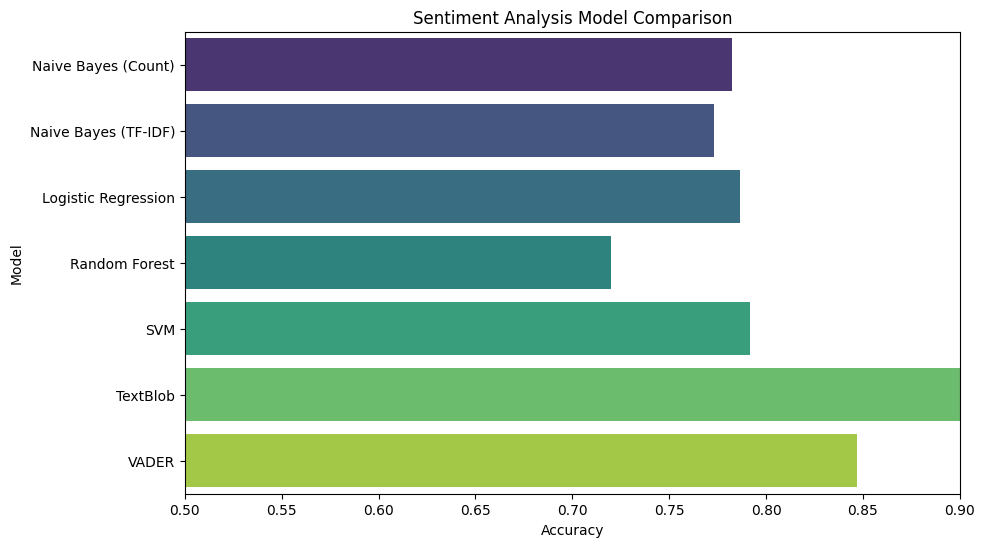

In [28]:
# Compare all models
results = {
    "Model": ["Naive Bayes (Count)", "Naive Bayes (TF-IDF)", "Logistic Regression", "Random Forest", "SVM", "TextBlob", "VADER"],
    "Accuracy": [accuracy_nb, accuracy_nb_tfidf, accuracy_lr, accuracy_rf, accuracy_svm, accuracy_tb, accuracy_vader]
}

results_df = pd.DataFrame(results)
print("\n=== Model Performance Comparison ===")
print(results_df)

# Plot results
plt.figure(figsize=(10, 6))
sns.barplot(x="Accuracy", y="Model", data=results_df, palette="viridis")
plt.title("Sentiment Analysis Model Comparison")
plt.xlim(0.5, 0.9)
plt.show()

In [32]:
def predict_sentiment(text):
    cleaned_text = clean(text)
    text_vec = vectorizer.transform([cleaned_text])
    prediction = model.predict(text_vec)
    return "Pozitiv" if prediction[0] == 1 else "Negativ"

# Testimi
test_tweet1 = "I love Machine Learning."
test_tweet2 = "I hate dogs."

print(f"\nSentimenti i Tweet-it '{test_tweet1}': {predict_sentiment(test_tweet1)}")
print(f"Sentimenti i Tweet-it '{test_tweet2}': {predict_sentiment(test_tweet2)}")


Sentimenti i Tweet-it 'I love Machine Learning.': Pozitiv
Sentimenti i Tweet-it 'I hate dogs.': Negativ
